In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
ad = sc.read_h5ad("08H089_allsorted_cleaned.h5")

/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
obs = ad.obs
unsort_ind = [i for i in range(ad.shape[0]) if "orted" not in ad.obs["sample"][i]]

In [4]:
np.unique(obs["sample"])

array(['08H089_1', '08H089_2', '08H089_Sorted_CD34',
       '08H089_Sorted_Double_P', '08H089_sorted', '08H089sorted2_1',
       '08H089sorted2_2'], dtype=object)

In [5]:
np.unique(obs.iloc[unsort_ind]["sample"])

array(['08H089_1', '08H089_2'], dtype=object)

In [6]:
#make separate object for unsorted cells so we can compare
unsorted = ad[unsort_ind,:]

In [8]:
ad.layers["counts"]=ad.X
sc.pp.calculate_qc_metrics(ad, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# 
ad.obs['original_total_counts'] = ad.obs['total_counts']

# log10 original library size
ad.obs['log10_original_total_counts'] = np.log10(ad.obs['original_total_counts'])

# Normalize by median library size
med = np.median(ad.obs['original_total_counts'])
sc.pp.normalize_per_cell(ad, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(ad)

In [9]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [10]:
sc.pp.calculate_qc_metrics(unsorted, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# 
unsorted.obs['original_total_counts'] = unsorted.obs['total_counts']

# log10 original library size
unsorted.obs['log10_original_total_counts'] = np.log10(unsorted.obs['original_total_counts'])

# Normalize by median library size
med = np.median(unsorted.obs['original_total_counts'])
sc.pp.normalize_per_cell(unsorted, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(unsorted)

/home/lf2684/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [11]:
sc.pp.neighbors(unsorted)
sc.tl.umap(unsorted)

In [75]:
new_label = []
for i in unsorted.obs["blast_cell_type_08H089"]:
    if i=="immature" or i=='blast0' or i=="blast1":
        new_label.append("immature")
    else:
        new_label.append("other")
palette = {'immature':'red',"other":"grey"}

In [76]:
unsorted.obs["cell type"]=new_label

In [14]:
obs = unsorted.obs
obs[obs["cell type"]=="immature"].shape

(179, 32)

In [15]:
def compute_mut(adata):
    fast_x = sklearn.decomposition.TruncatedSVD(100).fit_transform(adata.X)
    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
    nn.fit(fast_x)
    neighbors = nn.kneighbors(return_distance=False)

    npm_mut = (adata.obs["NPM1_mut"] == "mut").to_numpy()[neighbors].sum(axis=1)
    npm_wt = (adata.obs["NPM1_wt"] == "wt").to_numpy()[neighbors].sum(axis=1)
    #dnm_mut = (adata.obs["DNMT3A_mut"] == "mut").to_numpy()[neighbors].sum(axis=1)
    #dnm_wt = (adata.obs["DNMT3A_wt"] == "wt").to_numpy()[neighbors].sum(axis=1)

    npm_mut_ratio = npm_mut / (npm_mut + npm_wt + 1e-10)
    #dnm_mut_ratio = dnm_mut / (dnm_mut + dnm_wt + 1e-10)

    adata.obs["NPM1 mutation vs wild type"] = npm_mut_ratio
    #adata.obs["DNMT3A mutation vs wild type"] = dnm_mut_ratio
    return adata

unsorted = compute_mut(unsorted)

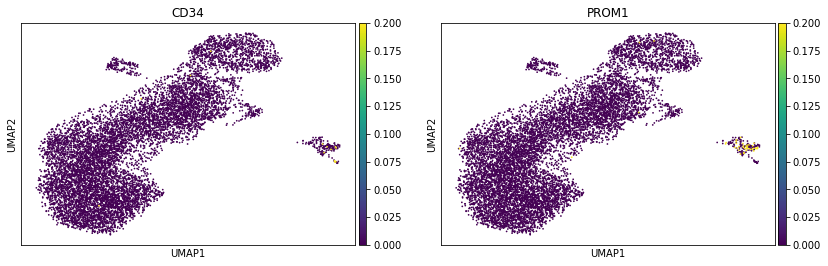

In [17]:
sc.pl.umap(unsorted,color=["CD34","PROM1"],vmax=.2,
           palette=palette,save="s2e_unsorted_umap.pdf")

In [21]:
sc.tl.rank_genes_groups(unsorted, groupby="cell type", use_raw=True)

In [24]:
df = sc.get.rank_genes_groups_df(unsorted, group="immature")
df.index = df["names"]

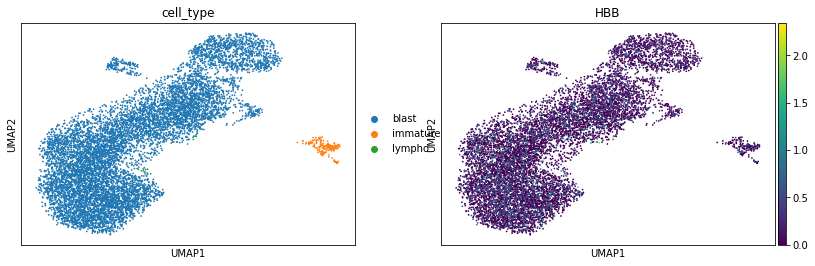

In [93]:
sc.pl.umap(unsorted,color=["cell_type","HBB"])

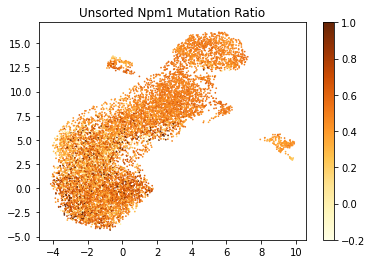

In [18]:
randomize=np.arange(unsorted.shape[0])
np.random.shuffle(randomize)
plt.scatter(unsorted.obsm["X_umap"][:,0][randomize],unsorted.obsm["X_umap"][:,1][randomize],rasterized=True,
                c=unsorted.obs["NPM1 mutation vs wild type"][randomize],vmin=-.2,vmax=1,cmap="YlOrBr",s=.5)
plt.colorbar()
plt.title("Unsorted Npm1 Mutation Ratio")
plt.savefig("figures/s2d_unsorted_muts.pdf")


In [22]:
colors = {"other":"grey","immature":"red"}

/home/lf2684/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


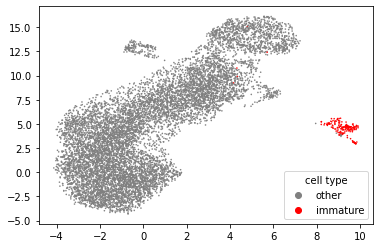

In [77]:
randomize=np.arange(unsorted.shape[0])
np.random.shuffle(randomize)
sns.scatterplot(unsorted.obsm["X_umap"][:,0][randomize],unsorted.obsm["X_umap"][:,1][randomize],hue=unsorted.obs["cell type"][randomize]
                ,palette=palette,s=2,vmax=.8,edgecolor=None)
plt.savefig("figures/4b_unsorted.pdf")

In [72]:
new_label = []
for i in ad.obs["blast_cell_type_08H089"]:
    if i=="immature" or i=='blast0' or i=='blast1':
        new_label.append("immature")
    else:
        new_label.append("other")
palette = {'immature':'red',"other":"grey"}

In [73]:
ad.obs["cell type"]=new_label
#sc.pl.umap(ad,color="new",palette=palette)

In [27]:
obs = ad.obs
obs[obs["cell type"]=="immature"].shape

(0, 32)

In [28]:
ad = compute_mut(ad)

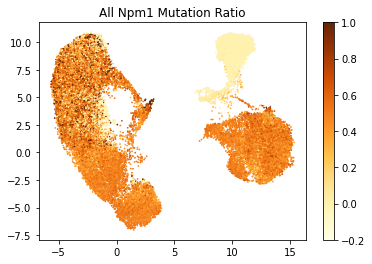

In [29]:
randomize=np.arange(ad.shape[0])
np.random.shuffle(randomize)
plt.scatter(ad.obsm["X_umap"][:,0][randomize],ad.obsm["X_umap"][:,1][randomize],
                c=ad.obs["NPM1 mutation vs wild type"][randomize],rasterized=True,vmin=-.2,vmax=1,cmap="YlOrBr",s=.5)
plt.colorbar()
plt.title("All Npm1 Mutation Ratio")
plt.savefig("figures/s2d_all_muts.pdf")


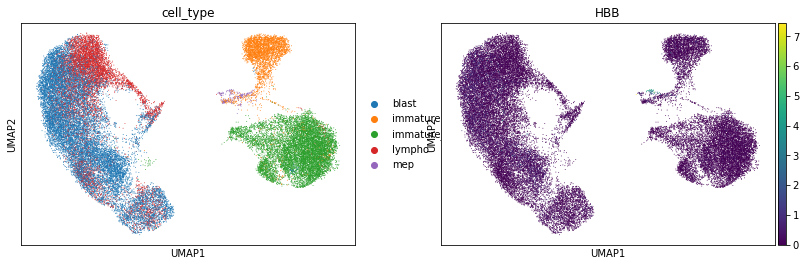

In [30]:
sc.pl.umap(ad,color=["cell_type","HBB"])

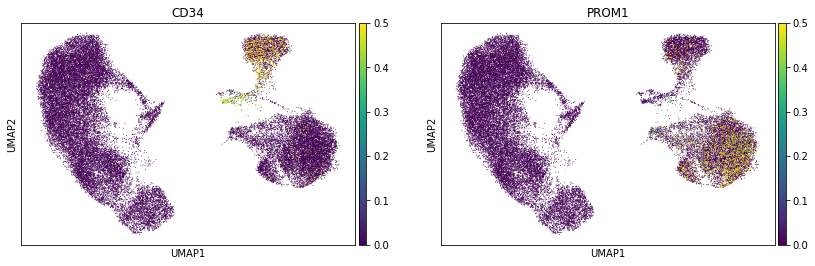

In [31]:
sc.pl.umap(ad,color=["CD34","PROM1"],vmax=.5,palette=palette,save="s2e_allcells_umap.pdf")

/home/lf2684/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


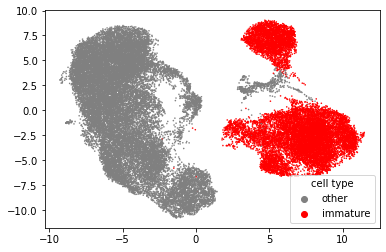

In [74]:
randomize=np.arange(ad.shape[0])
np.random.shuffle(randomize)
sns.scatterplot(ad.obsm["X_umap"][:,0][randomize],ad.obsm["X_umap"][:,1][randomize],hue=ad.obs["cell type"][randomize]
                ,palette=palette,s=2,vmax=.8,edgecolor=None)
plt.savefig("figures/4b_sorted.pdf")

In [19]:
def subsample(adata, select, key):
    #select is the column in adata.obs that we will subsample by
    #key is the entries in obs that we will select
    index=[]
    for i in range(len(adata.obs[select])):
        if adata.obs[select][i] in key:
            index.append(i)
    return adata[index,:]

In [46]:
obs = unsorted.obs
ct_immature = obs[obs["cell_type"]=="immature"].shape[0]
ct_immature_mut = obs[obs["cell_type"]=="immature_mutated"].shape[0]
print(ct_immature+ct_immature_mut)

179


In [68]:
ad = sc.read_h5ad("08H089_allsorted_cleaned.h5")

/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [70]:
obs = ad.obs
ct_b0 = obs[obs["blast_cell_type_08H089"] == "blast0"].shape[0]
ct_b1 = obs[obs["blast_cell_type_08H089"] == "blast1"].shape[0]
ct_im = obs[obs["blast_cell_type_08H089"] == "immature"].shape[0]
print(ct_b0+ct_b1+ct_im)

13210


In [65]:
ad = sc.read_h5ad("16H008_allsorted_cleaned.h5")

/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [67]:
obs = ad.obs
ct_b0 = obs[obs["blast_cell_type_16H008"] == "blast0"].shape[0]
ct_b1 = obs[obs["blast_cell_type_16H008"] == "blast1"].shape[0]
ct_im = obs[obs["blast_cell_type_16H008"] == "immature"].shape[0]
print(ct_b0+ct_b1+ct_im)

7941


In [54]:
ad = sc.read_h5ad("AML7_allsorted_cleaned.h5")

/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/lf2684/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [64]:
obs = ad.obs
ct_b0 = obs[obs["blast_cell_type_AML7"] == "blast0"].shape[0]
ct_b1 = obs[obs["blast_cell_type_AML7"] == "blast1"].shape[0]
ct_im = obs[obs["blast_cell_type_AML7"] == "immature"].shape[0]
print(ct_b0+ct_b1+ct_im)

8115


In [71]:
13210 + 7941 + 8115

29266